In [1]:
from __future__ import print_function

import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import SeparableConv1D, Conv1D, MaxPooling1D, LSTM
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

save_dir = os.path.join(os.getcwd(), 'saved_models')

from IPython.display import clear_output
from keras_helper import PlotProgress

%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 6

In [3]:
def get_confusion_matrix(Y, Y_hat):
    report = classification_report(
        y_true=Y.argmax(axis=1),
        y_pred=Y_hat.argmax(axis=1),
        labels=list(label_mapping.keys()),
        target_names=list(label_mapping.values())
    )
    return report

In [4]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entities=['loss']):
        self.entities = entities
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = {}
        self.val_losses = {}
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        
        for entity in self.entities:
            self.losses.update({
                '{}'.format(entity) : self.losses.get('{}'.format(entity), list()) + [logs.get('{}'.format(entity))]
            })
            self.val_losses.update({
                'val_{}'.format(entity) : self.val_losses.get('val_{}'.format(entity), list()) + [logs.get('val_{}'.format(entity))]
            })
        self.i += 1
        
        clear_output(wait=True)
        ncol = 2
        nrow = int(len(self.entities) / ncol) + 1
        plt.figure(figsize=(12, 8))
        
        for idx, entity in enumerate(self.entities):
            plt.subplot(nrow, ncol, idx + 1)
            plt.plot(self.x, self.losses.get("{}".format(entity)), label="{}".format(entity))
            plt.plot(self.x, self.val_losses.get("val_{}".format(entity)), label="val_{}".format(entity))
            plt.xlabel('epoch')
            plt.title(entity)
            plt.legend()
        plt.show();

In [5]:
body_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_x_train.txt', sep='\s+', header=None)
body_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_y_train.txt', sep='\s+', header=None)
body_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_z_train.txt', sep='\s+', header=None)

total_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_x_train.txt', sep='\s+', header=None)
total_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_y_train.txt', sep='\s+', header=None)
total_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_z_train.txt', sep='\s+', header=None)

body_gyro_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_x_train.txt', sep='\s+', header=None)
body_gyro_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_y_train.txt', sep='\s+', header=None)
body_gyro_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_z_train.txt', sep='\s+', header=None)

y_train = pd.read_csv('../data/har/train/y_train.txt', sep='\s+', header=None).values

In [6]:
body_acc_x_test = pd.read_csv('../data/har/test/Inertial_Signals/body_acc_x_test.txt', sep='\s+', header=None)
body_acc_y_test = pd.read_csv('../data/har/test/Inertial_Signals/body_acc_y_test.txt', sep='\s+', header=None)
body_acc_z_test = pd.read_csv('../data/har/test/Inertial_Signals/body_acc_z_test.txt', sep='\s+', header=None)

total_acc_x_test = pd.read_csv('../data/har/test/Inertial_Signals/total_acc_x_test.txt', sep='\s+', header=None)
total_acc_y_test = pd.read_csv('../data/har/test/Inertial_Signals/total_acc_y_test.txt', sep='\s+', header=None)
total_acc_z_test = pd.read_csv('../data/har/test/Inertial_Signals/total_acc_z_test.txt', sep='\s+', header=None)

body_gyro_x_test = pd.read_csv('../data/har/test/Inertial_Signals/body_gyro_x_test.txt', sep='\s+', header=None)
body_gyro_y_test = pd.read_csv('../data/har/test/Inertial_Signals/body_gyro_y_test.txt', sep='\s+', header=None)
body_gyro_z_test = pd.read_csv('../data/har/test/Inertial_Signals/body_gyro_z_test.txt', sep='\s+', header=None)

y_test = pd.read_csv('../data/har/test/y_test.txt', sep='\s+', header=None).values

In [7]:
label_info = pd.read_csv('../data/har/activity_labels.txt', sep='\s+', header=None)
label_mapping = dict()

for index, row_data in label_info.iterrows():
    label_mapping.update({row_data[0] -1 : row_data[1]})

In [8]:
X_train = np.stack([body_acc_x_train,
                    body_acc_y_train,
                    body_acc_z_train,
                    total_acc_x_train,
                    total_acc_y_train,
                    total_acc_z_train,
                    body_gyro_x_train,
                    body_gyro_y_train,
                    body_gyro_z_train,
                   ], axis=-1)

In [9]:
X_test = np.stack([body_acc_x_test,
                    body_acc_y_test,
                    body_acc_z_test,
                    total_acc_x_test,
                    total_acc_y_test,
                    total_acc_z_test,
                    body_gyro_x_test,
                    body_gyro_y_test,
                    body_gyro_z_test,
                   ], axis=-1)

In [10]:
encoder = OneHotEncoder(categories='auto')
Y_train = encoder.fit_transform(y_train).toarray()
Y_test = encoder.fit_transform(y_test).toarray()

In [11]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_test = X_test.astype('float32')
Y_test = Y_test.astype('float32')

In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                      Y_train,
                                                      test_size=0.2,
                                                      random_state=123)

In [13]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((5881, 128, 9), (5881, 6), (1471, 128, 9), (1471, 6))

In [14]:
n_timesteps, n_channels = X_train[0, :].shape
dropout_rate = 0.25

model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps,n_channels), return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(8))
model.add(Dropout(dropout_rate))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 32)           12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1152      
__________

In [16]:
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



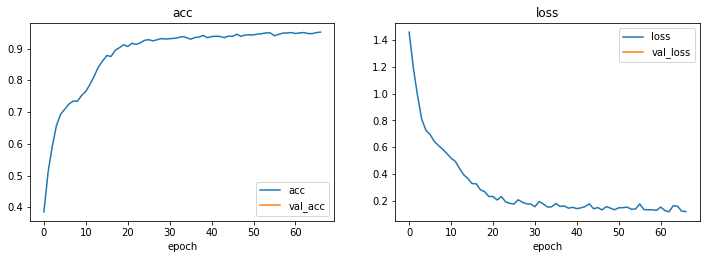

Epoch 68/100
5120/5881 [=========================>....] - ETA: 3s - loss: 0.1425 - acc: 0.9482

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
%%time
batch_size = 128
epochs = 100

plot_progress = PlotProgress(entities=['acc', 'loss'])

save_path = './keras-saves/_latest.ckpt'
try:
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
#               validation_data=(X_valid, Y_valid),
              callbacks=[plot_progress],
              shuffle=True,
         )
except KeyboardInterrupt:
#     model.save(save_path)
    print('\nOutput saved to: "{}./*"'.format(save_path))

In [18]:
from keras.utils.vis_utils import plot_model

In [19]:
plot_model(model, show_shapes=True)

In [20]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [21]:
X_test.shape, Y_test.shape

((2947, 128, 9), (2947, 6))

In [ ]:
print("Train Confusion Matrix\n", get_confusion_matrix(Y_train, model.predict(X_train)))
print("Validation Confusion Matrix\n", get_confusion_matrix(Y_valid, model.predict(X_valid)))
print("Test Confusion Matrix\n", get_confusion_matrix(Y_test, model.predict(X_test)))

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
from keras import backend as K
layer_name = 'conv1d_16'
filter_index = 0

layer_output = layer_dict[layer_name].output

In [ ]:
layer_dict[layer_name].get_weights()[0].shape

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model, to_file='../model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
grouped_mean_spectrogram = spects.groupby(y_train).apply(lambda group: np.mean([specg for frequencies, times, specg in group], axis=0))

In [ ]:
plt.figure(figsize=(20, 10))
for i in grouped_mean_spectrogram.index:
    plt.subplot(2, 3, i)
#     plt.yticks(frequencies)
    plt.imshow(grouped_mean_spectrogram[i], cmap='plasma')
    plt.title(label_mapping.get(i))

In [ ]:
plt.figure(figsize=(20, 20))

sample = 10
cat = 4

for i, (freqs, times, spec) in enumerate(spects.groupby(y_train).get_group(cat)[:sample]):
    plt.subplot(3, 4, i+1)
    plt.yticks(freqs)
    plt.imshow(spec, cmap='plasma')
    plt.title(label_mapping.get(cat))
